In [0]:
!rm -rf checkpoints && mkdir checkpoints

In [0]:
RANDOM_SEED = 42
DATASET_DIR = "./data"
TRAIN_PERCENTAGE = 0.75
AVOID_CLASS = "Black-grass"

In [0]:
import cv2
from glob import glob
import numpy as np
from matplotlib import pyplot as plt
import math
import pandas as pd
import os
import random
import shutil
import tensorflow as tf

np.random.seed(RANDOM_SEED)
tf.set_random_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [4]:
ScaleTo = 128  # px to scale

path_train = DATASET_DIR + '/train_augmented/*/*.png' 
files_train = glob(path_train)
trainImg = []
trainLabel = []
j = 1
num_train = len(files_train)

# Obtain images and resizing, obtain labels
for img in random.sample(files_train, len(files_train)):
    print(str(j) + "/" + str(num_train), end="\r")
    trainImg.append(cv2.resize(cv2.imread(img), (ScaleTo, ScaleTo)))  # Get image (with resizing)
    trainLabel.append(img.split('/')[-2])  # Get image label (folder name)
    j += 1

trainImg = np.asarray(trainImg)  # Train images set
trainLabel = pd.DataFrame(trainLabel)  # Train labels set

In [5]:
path_test = DATASET_DIR + '/test/*/*.png' 
files_test = glob(path_test)
testImg = []
testLabel = []
j = 1
num_test = len(files_test)

# Obtain images and resizing, obtain labels
for img in random.sample(files_test, len(files_test)):
    print(str(j) + "/" + str(num_test), end="\r")
    testImg.append(cv2.resize(cv2.imread(img), (ScaleTo, ScaleTo)))  # Get image (with resizing)
    testLabel.append(img.split('/')[-2])  # Get image label (folder name)
    j += 1

testImg = np.asarray(testImg)  # Test images set
testLabel = pd.DataFrame(testLabel)  # Test labels set

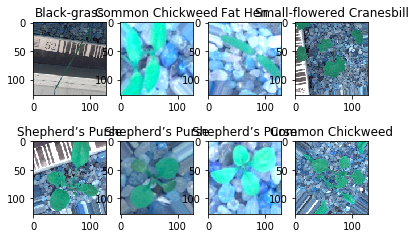

In [6]:
for i in range(8):
    r = trainLabel.iloc[i][0]
    plt.subplot(2, 4, i + 1)
    plt.imshow(trainImg[i])
    plt.title('{}'.format(r))

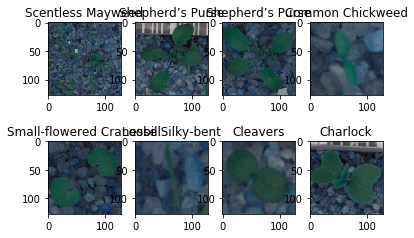

In [7]:
for i in range(8):
    r = testLabel.iloc[i][0]
    plt.subplot(2, 4, i + 1)
    plt.imshow(testImg[i])
    plt.title('{}'.format(r))

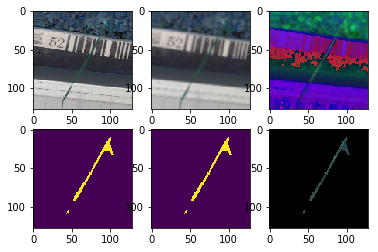

In [8]:
clearTrainImg = []
examples = []; getEx = True
for img in trainImg:
    # Use gaussian blur
    blurImg = cv2.GaussianBlur(img, (5, 5), 0)   
    
    # Convert to HSV image
    hsvImg = cv2.cvtColor(blurImg, cv2.COLOR_BGR2HSV)  
    
    # Create mask (parameters - green color range)
    lower_green = (25, 40, 50)
    upper_green = (75, 255, 255)
    mask = cv2.inRange(hsvImg, lower_green, upper_green)  
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Create bool mask
    bMask = mask > 0  
    
    # Apply the mask
    clear = np.zeros_like(img, np.uint8)  # Create empty image
    clear[bMask] = img[bMask]  # Apply boolean mask to the origin image
    
    clearTrainImg.append(clear)  # Append image without backgroung
    
    # Show examples
    if getEx:
        plt.subplot(2, 3, 1); plt.imshow(img)  # Show the original image
        plt.subplot(2, 3, 2); plt.imshow(blurImg)  # Blur image
        plt.subplot(2, 3, 3); plt.imshow(hsvImg)  # HSV image
        plt.subplot(2, 3, 4); plt.imshow(mask)  # Mask
        plt.subplot(2, 3, 5); plt.imshow(bMask)  # Boolean mask
        plt.subplot(2, 3, 6); plt.imshow(clear)  # Image without background
        getEx = False

clearTrainImg = np.asarray(clearTrainImg)

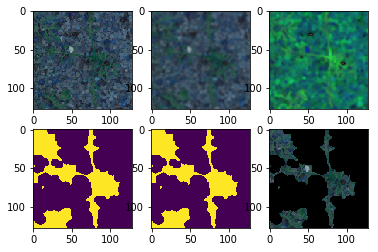

In [9]:
clearTestImg = []
examples = []; getEx = True
for img in testImg:
    # Use gaussian blur
    blurImg = cv2.GaussianBlur(img, (5, 5), 0)   
    
    # Convert to HSV image
    hsvImg = cv2.cvtColor(blurImg, cv2.COLOR_BGR2HSV)  
    
    # Create mask (parameters - green color range)
    lower_green = (25, 40, 50)
    upper_green = (75, 255, 255)
    mask = cv2.inRange(hsvImg, lower_green, upper_green)  
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Create bool mask
    bMask = mask > 0  
    
    # Apply the mask
    clear = np.zeros_like(img, np.uint8)  # Create empty image
    clear[bMask] = img[bMask]  # Apply boolean mask to the origin image
    
    clearTestImg.append(clear)  # Append image without backgroung
    
    # Show examples
    if getEx:
        plt.subplot(2, 3, 1); plt.imshow(img)  # Show the original image
        plt.subplot(2, 3, 2); plt.imshow(blurImg)  # Blur image
        plt.subplot(2, 3, 3); plt.imshow(hsvImg)  # HSV image
        plt.subplot(2, 3, 4); plt.imshow(mask)  # Mask
        plt.subplot(2, 3, 5); plt.imshow(bMask)  # Boolean mask
        plt.subplot(2, 3, 6); plt.imshow(clear)  # Image without background
        getEx = False

clearTestImg = np.asarray(clearTestImg)

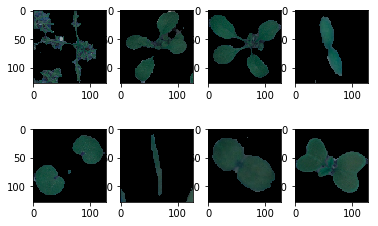

In [10]:
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(clearTestImg[i])

In [11]:
clearTestImg.shape

(1390, 128, 128, 3)

In [12]:
clearTrainImg.shape

(7200, 128, 128, 3)

In [0]:
clearTrainImg = clearTrainImg / 255

In [0]:
clearTestImg = clearTestImg / 255

Using TensorFlow backend.


Classes: ['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherd’s Purse' 'Small-flowered Cranesbill' 'Sugar beet']
Number of classes: 12


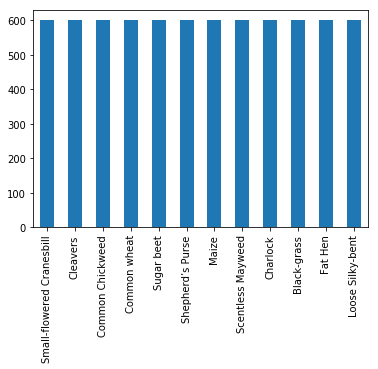

In [15]:
from keras.utils import np_utils
from sklearn import preprocessing

# Encode labels and create classes
le = preprocessing.LabelEncoder()
le.fit(trainLabel[0])
print("Classes: " + str(le.classes_))
encodeTrainLabels = le.transform(trainLabel[0])

# Make labels categorical
clearTrainLabel = np_utils.to_categorical(encodeTrainLabels)
num_clases = clearTrainLabel.shape[1]
print("Number of classes: " + str(num_clases))

# Plot of label types numbers
trainLabel[0].value_counts().plot(kind='bar')

In [0]:
from sklearn.model_selection import train_test_split

trainX, validX, trainY, validY = train_test_split(clearTrainImg, clearTrainLabel, 
                                                test_size=0.15, random_state=RANDOM_SEED, 
                                                stratify = clearTrainLabel)

In [20]:
trainX.shape

(6120, 128, 128, 3)

In [21]:
validX.shape

(1080, 128, 128, 3)

In [22]:
from tensorflow.keras.models import load_model
from sklearn.datasets import load_files   
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D, BatchNormalization

vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', 
                                        input_shape=(ScaleTo, ScaleTo, 3))
# Freeze the layers
vgg.trainable = True

#for layer in vgg.layers[:-4]:
#    layer.trainable = False
    
base_vgg = vgg
base_out = base_vgg.output
pool_out = tf.keras.layers.Flatten()(base_out)

fc1 = Dense(512, activation='relu')(pool_out)
bn1 = BatchNormalization()(fc1)
dp1 = Dropout(0.5)(bn1)

fc2 = Dense(512, activation='relu')(dp1)
bn2 = BatchNormalization()(fc2)
dp2 = Dropout(0.5)(bn2)

output = Dense(num_clases, activation= 'softmax')(dp2)
model = Model(inputs = vgg.input, outputs = output)

model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
80142336/80134624 [==============================] - 3s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping

#trainY_ints = [y.argmax() for y in trainY]

# learning rate reduction
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.4, 
                                            min_lr=0.00001)

early_stop = EarlyStopping(monitor='val_acc', 
                           patience=25, 
                           verbose=1)

# checkpoints
filepath="checkpoints/weights.best_{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', 
                             verbose=1, save_best_only=True, mode='max')
filepath="checkpoints/weights.last_auto4.hdf5"
checkpoint_all = ModelCheckpoint(filepath, monitor='val_acc', 
                                 verbose=1, save_best_only=False, mode='max')

# all callbacks
callbacks_list = [checkpoint, learning_rate_reduction, early_stop, checkpoint_all]

# fit model
hist = model.fit(trainX, trainY, batch_size=128, epochs=100, validation_data=(validX, validY), callbacks=callbacks_list, verbose=1)

Train on 6120 samples, validate on 1080 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
6016/6120 [============================>.] - ETA: 0s - loss: 3.3489 - acc: 0.1302
Epoch 00001: val_acc improved from -inf to 0.08333, saving model to checkpoints/weights.best_01-0.08.hdf5

Epoch 00001: saving model to checkpoints/weights.last_auto4.hdf5
6120/6120 [==============================] - 58s 10ms/sample - loss: 3.3406 - acc: 0.1314 - val_loss: 5.9986 - val_acc: 0.0833
Epoch 2/100
6016/6120 [============================>.] - ETA: 0s - loss: 2.8545 - acc: 0.1777
Epoch 00002: val_acc did not improve from 0.08333

Epoch 00002: saving model to checkpoints/weights.last_auto4.hdf5
6120/6120 [==============================] - 36s 6ms/sample - loss: 2.8503 - acc: 0.1784 - val_loss: 10.0745 - val_acc: 0.0833
Epoch 3/100
6016/6120 [============================>.] - ETA: 0s - loss: 2.3817 - acc: 0.2630
Epoch 00003: val_acc improved from 0.08333 to 0.08981, saving model to checkpoin

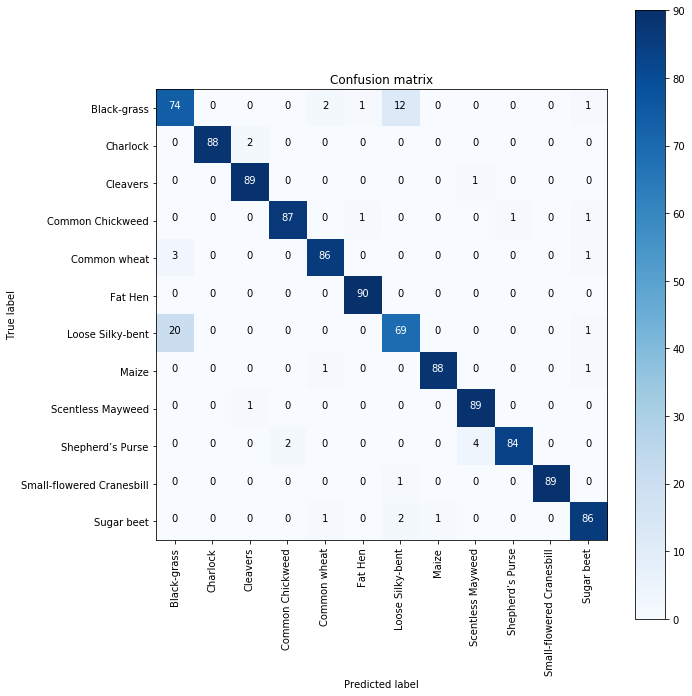

In [25]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    fig = plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
predY = model.predict(validX)
predYClasses = np.argmax(predY, axis = 1) 
trueY = np.argmax(validY, axis = 1) 

# confusion matrix
confusionMTX = confusion_matrix(trueY, predYClasses) 
# plot the confusion matrix
plot_confusion_matrix(confusionMTX, classes = le.classes_) 

<Figure size 432x288 with 0 Axes>

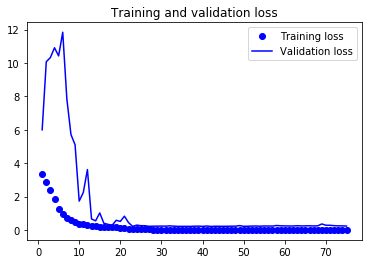

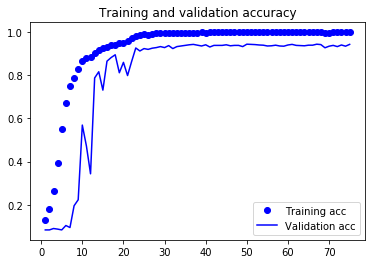

<Figure size 432x288 with 0 Axes>

In [26]:
import matplotlib.pyplot as plt
history = hist

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

In [0]:
!mkdir checkpoints

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file="file.png")

In [27]:
from sklearn.metrics import classification_report

# Generate a classification report

# Get the true labels
y_true = trueY

# For this to work we need y_pred as binary labels not as probabilities
y_pred_binary = predY.argmax(axis=1)

report = classification_report(y_true, y_pred_binary, target_names=le.classes_)

print(report)

                           precision    recall  f1-score   support

              Black-grass       0.76      0.82      0.79        90
                 Charlock       1.00      0.98      0.99        90
                 Cleavers       0.97      0.99      0.98        90
         Common Chickweed       0.98      0.97      0.97        90
             Common wheat       0.96      0.96      0.96        90
                  Fat Hen       0.98      1.00      0.99        90
         Loose Silky-bent       0.82      0.77      0.79        90
                    Maize       0.99      0.98      0.98        90
        Scentless Mayweed       0.95      0.99      0.97        90
         Shepherd’s Purse       0.99      0.93      0.96        90
Small-flowered Cranesbill       1.00      0.99      0.99        90
               Sugar beet       0.95      0.96      0.95        90

                micro avg       0.94      0.94      0.94      1080
                macro avg       0.94      0.94      0.94    

In [28]:
ls checkpoints

weights.best_01-0.08.hdf5  weights.best_14-0.82.hdf5  weights.best_31-0.94.hdf5
weights.best_03-0.09.hdf5  weights.best_16-0.87.hdf5  weights.best_35-0.94.hdf5
weights.best_06-0.10.hdf5  weights.best_17-0.88.hdf5  weights.best_36-0.94.hdf5
weights.best_08-0.20.hdf5  weights.best_18-0.90.hdf5  weights.best_37-0.94.hdf5
weights.best_09-0.22.hdf5  weights.best_23-0.93.hdf5  weights.best_50-0.94.hdf5
weights.best_10-0.57.hdf5  weights.best_28-0.93.hdf5  weights.last_auto4.hdf5
weights.best_13-0.79.hdf5  weights.best_29-0.93.hdf5


In [0]:
model.load_weights("checkpoints/weights.best_50-0.94.hdf5")

In [0]:
predicts = model.predict(clearTestImg, batch_size=128)

In [31]:
pred_labels = le.inverse_transform([np.argmax(pred) for pred in predicts])

(1390,)


In [0]:
testLabel

In [32]:
from sklearn import metrics
report = metrics.classification_report(testLabel, pred_labels)
print(report)

                           precision    recall  f1-score   support

              Black-grass       0.56      0.77      0.65        78
                 Charlock       1.00      0.98      0.99       113
                 Cleavers       0.98      0.98      0.98        84
         Common Chickweed       0.99      0.98      0.98       179
             Common wheat       0.78      0.97      0.87        64
                  Fat Hen       0.99      0.94      0.97       135
         Loose Silky-bent       0.93      0.75      0.83       191
                    Maize       0.94      0.97      0.95        65
        Scentless Mayweed       0.95      0.97      0.96       152
         Shepherd’s Purse       0.96      0.96      0.96        69
Small-flowered Cranesbill       1.00      1.00      1.00       144
               Sugar beet       1.00      0.98      0.99       116

                micro avg       0.93      0.93      0.93      1390
                macro avg       0.92      0.94      0.93    